In [64]:
# Importing the relevant libraries
import IPython.display
import json
import pandas as pd
import seaborn as sns
#import squarify
%matplotlib inline
import random
#import missingno as msno
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import numpy as np
from matplotlib import pyplot as plt

# D3 modules
from IPython.core.display import display, HTML, Javascript
from string import Template# The data to load

# Data Import

Because the training data is so large (125 Million rows), we will begin by taking a random sample of the rows to have a valid representative sample. My initial approach was to simply grab random rows from the training data, but upon further consideration, it's more appropriate to have all the data for a subset of the items. This way, we can obtain a better picture of the time-series continuity required for accurate predictions.

In [88]:
items = pd.read_csv("Data/items.csv")
holiday_events = pd.read_csv("Data/holidays_events.csv",parse_dates=['date'])
stores = pd.read_csv("Data/stores.csv")
oil = pd.read_csv("Data/oil.csv",parse_dates=['date'])
transactions = pd.read_csv("Data/transactions.csv",parse_dates=['date'])
test = pd.read_csv("Data/test.csv",parse_dates=['date'])

In [66]:
%%time

# Grab all unique item_nbr from items file
f = items['item_nbr'].unique()

# Count the lines
num_lines = f.size

# Sample size - in this case ~5% of items
size = int(num_lines / 20)

# Grab a random subset of size size from f
skip_idx = random.sample(list(f), size)
print(len(skip_idx))

# create a dataframe of the items we want to look at
items = items[items['item_nbr'].isin(skip_idx)]

# Read the entire training data
train = pd.read_csv("Data/train.csv", parse_dates=['date'] )

# Filter to only include training data for the subset of items we want
train = train[train['item_nbr'].isin(items['item_nbr'])]

205


<string>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 6min 44s


# Dealing with Missing Dates in the Training Set

Examining the train DataFrame, we find that if an item had no sales at a store location on a particular day, no row exists for that store/item pair for that date. To provide a better picture for our training algorithms, it makes sense to add these missing rows and assign the unit_sales a value of 0. 

In [67]:
# Make sure the date column is of the datetime data type. 
train['date'] = pd.to_datetime(train['date'])

In [68]:
# Create a datetime index that contains all the dates within our whole data range
# Because there are duplicate dates in the column, we take the mean of the dates on a particular date, 
#which is effectively just the date we want
dates = train.set_index('date').resample('D').mean().index

In [69]:
# We also want all the unique item_nbrs and store_nbrs
item_nbrs = train['item_nbr'].unique()
store_nbrs = train['store_nbr'].unique()

In [70]:
# We create a MultiIndex which will contain every possible date/item_nbr/store_nbr combination
idx = pd.MultiIndex.from_product((dates, item_nbrs, store_nbrs), names=['date', 'item_nbr', 'store_nbr'])

In [71]:
# We set the index of train to the new MultiIndex
# Now every item/store pair is represented on each date
train = train.set_index(['date', 'item_nbr', 'store_nbr']).reindex(idx).reset_index()

Now that we have the train DataFrame, we need to fill in null unit_sales values with 0 because no units were sold that day at that location. 

In [72]:
train.loc[:, 'unit_sales'].fillna(0, inplace=True) # Replaces null values with 0
del train['id'] # the old id column is meaningless and can be deleted

# Checking for Null Values

A good first step is to see which columns in which dataframes contain null values. If these appear, we will need to deal with these in some way. 

In [73]:
print("Nulls in train columns: {0} => {1}".format(train.columns.values, train.isnull().any().values))

Nulls in train columns: ['date' 'item_nbr' 'store_nbr' 'unit_sales' 'onpromotion'] => [False False False False  True]


The onpromotion column of the train dataframe contains null values.

In [74]:
print("Nulls in test columns: {0} => {1}".format(test.columns.values, test.isnull().any().values))

Nulls in test columns: ['id' 'date' 'store_nbr' 'item_nbr' 'onpromotion'] => [False False False False False]


In [75]:
print("Nulls in items columns: {0} => {1}".format(items.columns.values, items.isnull().any().values))

Nulls in items columns: ['item_nbr' 'family' 'class' 'perishable'] => [False False False False]


In [76]:
print("Nulls in holiday_events columns: {0} => {1}".format(holiday_events.columns.values, holiday_events.isnull().any().values))

Nulls in holiday_events columns: ['date' 'type' 'locale' 'locale_name' 'description' 'transferred'] => [False False False False False False]


In [77]:
print("Nulls in stores columns: {0} => {1}".format(stores.columns.values, stores.isnull().any().values))

Nulls in stores columns: ['store_nbr' 'city' 'state' 'type' 'cluster'] => [False False False False False]


In [78]:
print("Nulls in oil columns: {0} => {1}".format(oil.columns.values, oil.isnull().any().values))

Nulls in oil columns: ['date' 'dcoilwtico'] => [False  True]


In [79]:
print("Nulls in transactions columns: {0} => {1}".format(transactions.columns.values, transactions.isnull().any().values))

Nulls in transactions columns: ['date' 'store_nbr' 'transactions'] => [False False False]


It looks like there are two columns that contain null values. One is the onpromotion column of the train data, and the other is the dcoilwtico column of the oil price data. 

# Dealing with Null Values

The first column that contains null values is the onpromotion column of the train data. My initial thought was to simply change all the null values to false. However, this has the potential to mislead predictions. Instead, I followed the suggestion on the website provided to set missing values to 2, True to 1, and False to 0. 

Credit goes to: http://kevincsong.com/Kaggle-Pt.1-Favorita-Grocery-Sales-Prediction-Data-Engineering/

In [48]:
#train.loc[:, 'onpromotion'].fillna('Null', inplace=True) # Replaces null values with 2

In [49]:
#train.loc[:, 'onpromotion'].replace(True, 'T', inplace=True) # Replace True values with 1

In [50]:
#train.loc[:, 'onpromotion'].replace(False, 'F', inplace=True) # Replace False values with 0

It makes sense to make analogous changes in the test file.

In [51]:
#test.loc[:, 'onpromotion'].fillna('Null', inplace=True) # Replaces null values with 2

In [52]:
#test.loc[:, 'onpromotion'].replace(True, 'T', inplace=True) # Replace True values with 1

In [53]:
#test.loc[:, 'onpromotion'].replace(False, 'F', inplace=True) # Replace False values with 0

Check to see if the changes occurred as expected.

In [54]:
train.head()

,date,item_nbr,store_nbr,unit_sales,onpromotion
0,2013-01-01,108786,25,3.0,Null
1,2013-01-01,108786,1,0.0,Null
2,2013-01-01,108786,2,0.0,Null
3,2013-01-01,108786,3,0.0,Null
4,2013-01-01,108786,4,0.0,Null


In [55]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,F
1,125497041,2017-08-16,1,99197,F
2,125497042,2017-08-16,1,103501,F
3,125497043,2017-08-16,1,103520,F
4,125497044,2017-08-16,1,103665,F


Success

The second column that contains null values is the dcoilwtico in the oil file. It will probably be best to interpolate the missing values in some way. To start, I looked at the rows that are null. It appears there are only about 43 dates out of 1218 that are missing values. I will go ahead and simply backfill the oil prices. 

In [80]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null datetime64[ns]
dcoilwtico    1175 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.1 KB


In [81]:
# Replace NaN values using backward fill to cover first date 
oil['dcoilwtico'].fillna(method='bfill', inplace=True)

In [82]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null datetime64[ns]
dcoilwtico    1218 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.1 KB


No more null values in the oil price column.

# Add Day of Week and Day of Year

I came across a very clever idea to include the day of the week and day of the year as separate columns in the training data. This way our solution could find patterns regarding the day of the week, which probably plays a huge role in sales. It's expected that sales increase on the weekends. Special thanks to Kevin Song: 
http://kevincsong.com/Kaggle-Pt.1-Favorita-Grocery-Sales-Prediction-Data-Engineering/

In [83]:
# Add 'dow' and 'doy'
train['dow'] = train['date'].dt.dayofweek # adding day of week as a feature

test['dow'] = test['date'].dt.dayofweek # adding day of week as a feature

In [85]:
train = pd.get_dummies(train, columns=['dow', 'onpromotion'], drop_first=True)

In [91]:
test = pd.get_dummies(test, columns=['dow', 'onpromotion'], drop_first=True)

Because the day of the week is a categorical variable, we may improve our learning algorithm's results if we use categorical encoding. 

# Merge the Data into a Single DataFrame

In [93]:
train_merged = pd.merge(train, stores, on='store_nbr', how='left')
train_merged = pd.merge(train_merged, items, on='item_nbr', how='left')
train_merged = pd.merge(train_merged, oil, on='date', how='left')
train_merged = pd.merge(train_merged, holiday_events, on='date', how='left')

train_merged.head()

,date,item_nbr,store_nbr,unit_sales,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,...,cluster,family,class,perishable,dcoilwtico,type_y,locale,locale_name,description,transferred
0,2013-01-01,105575,25,2.0,1,0,0,0,0,0,...,1,GROCERY I,1045,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,105575,1,0.0,1,0,0,0,0,0,...,13,GROCERY I,1045,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,105575,2,0.0,1,0,0,0,0,0,...,13,GROCERY I,1045,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,105575,3,0.0,1,0,0,0,0,0,...,8,GROCERY I,1045,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,105575,4,0.0,1,0,0,0,0,0,...,9,GROCERY I,1045,0,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [94]:
for i in train_merged.columns:
    print(i, train_merged[i].isnull().any())

date False
item_nbr False
store_nbr False
unit_sales False
dow_1 False
dow_2 False
dow_3 False
dow_4 False
dow_5 False
dow_6 False
onpromotion_True False
city False
state False
type_x False
cluster False
family False
class False
perishable False
dcoilwtico True
type_y True
locale True
locale_name True
description True
transferred True


One thing that sticks out is that the oil price is NaN whenever the day of the week is 5 or 6. This means that the oil price isn't tracked on the weekends. This makes sense and it will probably be sufficient to forwardfill using Friday oil prices.

In [95]:
# Replace NaN values using forward fill to cover weekend dates using Friday's oil prices 
train_merged['dcoilwtico'].fillna(method='ffill', inplace=True)

In [ ]:
train_merged.to_csv('Data\MergedTrainData.csv')

# Sampling a Specific Item

Just as a sanity check, I thought it would be a good idea to sample a particular item at a particular location to see what the data looked like. 

In [94]:
PN119024 = train_merged[train_merged['item_nbr'] == 108952]

In [95]:
PN119024 = PN119024[PN119024['store_nbr'] == 25]

In [99]:
PN119024 = PN119024[PN119024['unit_sales'] > 12]

In [102]:
PN119024

,date,item_nbr,store_nbr,id,unit_sales,onpromotion,dow,doy,city,state,...,cluster,family,class,perishable,dcoilwtico,type_y,locale,locale_name,description,transferred
7155648,2014-10-10,108952,25,32740513.0,15.0,1,4,283,Salinas,Santa Elena,...,1,CLEANING,3024,0,85.87,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
8006472,2014-12-26,108952,25,38176877.0,27.0,0,4,360,Salinas,Santa Elena,...,1,CLEANING,3024,0,54.59,Bridge,National,Ecuador,Puente Navidad,False
8006473,2014-12-26,108952,25,38176877.0,27.0,0,4,360,Salinas,Santa Elena,...,1,CLEANING,3024,0,54.59,Additional,National,Ecuador,Navidad+1,False
8028288,2014-12-27,108952,25,38252179.0,17.0,0,5,361,Salinas,Santa Elena,...,1,CLEANING,3024,0,54.59,NaN,NaN,NaN,NaN,NaN
8061012,2014-12-30,108952,25,38475580.0,17.0,0,1,364,Salinas,Santa Elena,...,1,CLEANING,3024,0,54.14,NaN,NaN,NaN,NaN,NaN
8071920,2014-12-31,108952,25,38551149.0,20.0,0,2,365,Salinas,Santa Elena,...,1,CLEANING,3024,0,53.45,Additional,National,Ecuador,Primer dia del ano-1,False
8486424,2015-02-07,108952,25,40737781.0,14.0,0,5,38,Salinas,Santa Elena,...,1,CLEANING,3024,0,51.66,NaN,NaN,NaN,NaN,NaN
8573688,2015-02-15,108952,25,41216529.0,13.0,0,6,46,Salinas,Santa Elena,...,1,CLEANING,3024,0,52.66,NaN,NaN,NaN,NaN,NaN
10515312,2015-08-09,108952,25,53503089.0,15.0,0,6,221,Salinas,Santa Elena,...,1,CLEANING,3024,0,43.87,NaN,NaN,NaN,NaN,NaN
11420676,2015-10-31,108952,25,60765570.0,16.0,0,5,304,Salinas,Santa Elena,...,1,CLEANING,3024,0,46.60,NaN,NaN,NaN,NaN,NaN


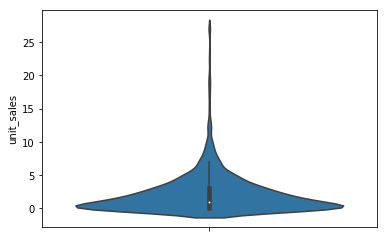

In [97]:
_ = sns.violinplot(y="unit_sales", data=PN119024)